# Text Classification

Vamos a hacer una clasificación de las cartas Magic en los 5 colores que existen. Vamos a utilizar el texto de reglas de las cartas, y luego veremos cómo podemos hacerlo funcionar con el texto de ambientación.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.preprocessing import Preprocessor

## Cargar el dataset
Lo primero que tenemos que hacer es cargar el dataset con los datos. Por el momento, nos vamos a quedar sólo con el color de la carta y el texto.

In [2]:
local_file = 'data/en.csv'
df = pd.read_csv(local_file, sep=';', encoding="utf-8")
df = df[['color', 'text']]
df.head(5)

,color,text
0,Black,"Whenever you gain life, put a +1/+1 counter on..."
1,Green,"When Borderland Ranger enters the battlefield,..."
2,Black,Lifelink
3,Blue,Other Merfolk creatures you control get +1/+1....
4,Black,Flying Whenever a creature you control deals c...


### Analizar los datos

Vamos a ver los datos y comprobar que sean aptos para la clasificación. Lo primero que vemos es que sólo tenemos 5 colores diferentes. Además, vemos que no hay ningún valor nulo en el texto ni en el color. Eso es porque hemos limpiado el dataset antes, hemos eliminado las cartas con valores nulos en el texto o en el color. Además, sólo nos hemos quedado con las cartas que tengan un sólo color.

In [3]:
df.describe()

,color,text
count,9619,9619
unique,5,5320
top,Green,Flying
freq,2136,181


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9619 entries, 0 to 9618
Data columns (total 2 columns):
color    9619 non-null object
text     9619 non-null object
dtypes: object(2)
memory usage: 150.4+ KB


Además, vemos que más o menos la distribución de cartas por color es equitativa, y por lo tanto, no tenemos valores desbalanceados para la clasificación.

<AxesSubplot:>

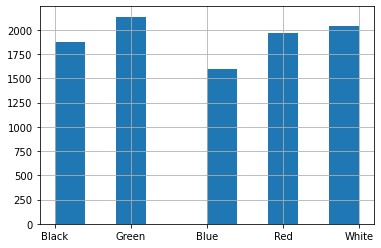

In [10]:
df['color'].hist()

## Preprocesado
Ahora vamos a preprocesar todos los textos con lo que hemos visto antes.

1. Creamos un métodos de Preprocesado
2. Lo aplicamos a todas las filas y creamos una nueva columna con el texto procesado.

In [12]:
def preprocess(preprocessor, text):
    return preprocessor.set_text(text).pipeline().get_text() # pipeline() = standardize().remove_stop_words().lemmatization()

In [13]:
preprocessor = Preprocessor()
df['preprocessed_text'] = df['text'].apply(lambda text: preprocess(preprocessor, text))
df.head()

,color,text,preprocessed_text
0,Black,"Whenever you gain life, put a +1/+1 counter on...",whenever gain life put counter bloodbond vampire
1,Green,"When Borderland Ranger enters the battlefield,...",borderland ranger enter battlefield may search...
2,Black,Lifelink,lifelink
3,Blue,Other Merfolk creatures you control get +1/+1....,merfolk creature control get target merfolk cr...
4,Black,Flying Whenever a creature you control deals c...,fly whenever creature control deal combat dama...


## Preparar los datos para FastText

A continuación, tenemos que preparar los datos para que FastText pueda interpretarlos. Para ello, tenemos que etiquetar cada text con su color, usando este formato:

```
__label__Color texto de la carta
```

Vamos a etiquetar los datos y a partir el dataset en datos de entrenamiento y test (70/30).

In [27]:
from sklearn.model_selection import train_test_split

In [19]:
def create_labered_data(df):
    labeled_data = df.apply(lambda x: f"__label__{str(x['color'])} {x['preprocessed_text']}", axis=1)
    return train_test_split(labeled_data, test_size=0.3)

In [20]:
train_data, test_data = create_labered_data(df)
print(train_data[:5])
print(test_data[:5])

6185    __label__Blue tempest caller enter battlefield...
6096                                    __label__Blue fly
863     __label__Black shadow creature block block cre...
6668    __label__White fly long dearly depart graveyar...
3052    __label__White fly whenever cast enchantment s...
dtype: object
8054    __label__Blue fly creature can not block excep...
6737    __label__White auriok survivor enter battlefie...
56      __label__Red mogg conscript can not attack unl...
8448    __label__Black herald dreadhorde die amass put...
3814    __label__Red whenever draw 2 card turn create ...
dtype: object


Para que FastTest puedo leer los datos y entrenar el clasificasificador, tenemos que guardar los datos de entrenamiento y test en ficheros.

In [25]:
def save_data(data, filename):
    with open(filename, 'w', encoding="utf-8") as oufile:
        for sent in data:
            oufile.write(sent + ' \n')

In [26]:
TRAIN_FILENAME = ".train"
TEST_FILENAME = ".test"

save_data(train_data, TRAIN_FILENAME)
save_data(test_data, TEST_FILENAME)

## Entenamiento

Ahora ya podemos entrenar el modelo.

In [28]:
from fasttext import train_supervised

In [30]:
model = train_supervised(input=TRAIN_FILENAME, epoch=10, lr=1, wordNgrams=2)

## Test

Ahora podemos hacer un test del modelo con los datos de test.

In [53]:
model.test(TEST_FILENAME)

(2886, 0.8264033264033264, 0.8264033264033264)

## Inferencia

Una vez tenemos el model entrenado, ya lo podemos utilizar para inferir el color de una carta por su texto.

In [54]:
def predict(model, query):
    preprocessor = Preprocessor()
    preprocess_text = preprocessor.set_text(query).pipeline().get_text()
    return model.predict(preprocess_text)[0][0].replace('__label__', '')


In [59]:
for card in df.sample(10).to_dict('records'):
    prediction = predict(model, card['text'])
    print(f"{'✅' if card['color'] == prediction else '❌'} [{card['color']}, {prediction}] {card['text']}\n")

✅ [Red, Red] Whenever Bull-Rush Bruiser attacks, if your team controls another Warrior, Bull-Rush Bruiser gains first strike until end of turn.

✅ [Blue, Blue] When Omenspeaker enters the battlefield, scry 2. (Look at the top two cards of your library, then put any number of them on the bottom of your library and the rest on top in any order.)

✅ [Blue, Blue] Flying {U}: Drake Hatchling gets +1/+0 until end of turn. Activate this ability only once each turn.

✅ [Red, Red] {1}{R}: Goblin Ski Patrol gets +2/+0 and gains flying. Its controller sacrifices it at the beginning of the next end step. Activate this ability only once and only if you control a snow Mountain.

✅ [Red, Red] {T}: Orcish Artillery deals 2 damage to any target and 3 damage to you.

✅ [Green, Green] Trample Whenever Primeval Titan enters the battlefield or attacks, you may search your library for up to two land cards, put them onto the battlefield tapped, then shuffle your library.

❌ [White, Blue] Defender (This creat

## Ejercicio

Ya hemos visto cómo hacer un clasificador de texto con FastText con muy buenos resultados. Ahora vamos a probar a clasificar las cartas por color, según su texto de ambientación. También puedes probar a cambiar los hyperparámetros de FastText.

Aquí tienes el código básico del ejemplo que hemos visto antes. Cámbialo para clasificar por el `flavor` text.

¿Qué puedes probar?
- Modificar el preprocesado ¿qué pasa si no preprocesamos el texto?
- Desbalancear un color
- Clasificar por el `flavor` text
- Modificar los hyperparámetros de FastText

In [76]:
# Cargar los datos
CLASSIFY_BY = 'text'

local_file = 'data/en.csv'
df = pd.read_csv(local_file, sep=';', encoding="utf-8")
df = df[['color', CLASSIFY_BY]]

# Preprocesar
def preprocess(preprocessor, text):
    return preprocessor.set_text(text).pipeline().get_text() # pipeline() = standardize().remove_stop_words().lemmatization()

preprocessor = Preprocessor()
df['preprocessed_text'] = df[CLASSIFY_BY].apply(lambda text: preprocess(preprocessor, text))

# Preparar los datos para FastText
def create_labered_data(df):
    labeled_data = df.apply(lambda x: f"__label__{str(x['color'])} {x['preprocessed_text']}", axis=1)
    return train_test_split(labeled_data, test_size=0.3)

def save_data(data, filename):
    with open(filename, 'w', encoding="utf-8") as oufile:
        for sent in data:
            oufile.write(sent + ' \n')

train_data, test_data = create_labered_data(df)
TRAIN_FILENAME = ".train"
TEST_FILENAME = ".test"

save_data(train_data, TRAIN_FILENAME)
save_data(test_data, TEST_FILENAME)

# Entrenamiento
model = train_supervised(input=TRAIN_FILENAME, epoch=10, lr=1, wordNgrams=2)

# Test
print(model.test(TEST_FILENAME))

# Inferencia
def predict(model, query):
    preprocessor = Preprocessor()
    preprocess_text = preprocessor.set_text(query).pipeline().get_text()
    return model.predict(preprocess_text)[0][0].replace('__label__', '')

for card in df.sample(10).to_dict('records'):
    prediction = predict(model, card[CLASSIFY_BY])
    print(f"{'✅' if card['color'] == prediction else '❌'} [{card['color']}, {prediction}] {card[CLASSIFY_BY]}\n")

(2886, 0.8208593208593209, 0.8208593208593209)
✅ [Red, Red] Mentor (Whenever this creature attacks, put a +1/+1 counter on target attacking creature with lesser power.) {1}{R}: Goblin Banneret gets +2/+0 until end of turn.

✅ [Blue, Blue] Islandwalk (This creature cant be blocked as long as defending player controls an Island.)

✅ [Red, Red] Denimwalk (This creature cant be blocked as long as defending player is wearing denim.)

✅ [Blue, Blue] {T}: Target land becomes an Island until end of turn.

✅ [Red, Red] {2}{R}, {T}, Put a -1/-1 counter on a creature you control: Hatchet Bully deals 2 damage to any target.

✅ [Blue, Blue] Flying {U}: Advanced Hoverguard gains shroud until end of turn. (It cant be the target of spells or abilities.)

✅ [White, White] {4}{G}: Rockcaster Platoon deals 2 damage to each creature with flying and each player.

✅ [White, White] Flanking (Whenever a creature without flanking blocks this creature, the blocking creature gets -1/-1 until end of turn.) {1}{W}